In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy import stats
import itertools
from mintpy.utils import network, plot

In [2]:
def norm_data(data):
    """
    normalize data to have mean=0 and standard_deviation=1
    """
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    #return (data-mean_data)/(std_data*np.sqrt(data.size-1))
    return (data-mean_data)/(std_data)


def ncc(data0, data1):
    """
    normalized cross-correlation coefficient between two data sets

    Parameters
    ----------
    data0, data1 :  numpy arrays of same size
    """
    return (1.0/(data0.size-1)) * np.sum(norm_data(data0)*norm_data(data1))


In [3]:
cd /mnt/i/sentinel2/yearly_nir

/mnt/i/sentinel2/yearly_nir


In [4]:
# b08dat = glob.glob('*B08_10m*.dat')
s2s = glob.glob('*tif')

names = {os.path.basename(x)[6:14]:x for x in s2s}
names

{'20160601': 's2_l2_20160601.tif',
 '20170601': 's2_l2_20170601.tif',
 '20180601': 's2_l2_20180601.tif',
 '20190601': 's2_l2_20190601.tif',
 '20200601': 's2_l2_20200601.tif',
 '20210601': 's2_l2_20210601.tif'}

In [6]:
df = pd.DataFrame()

pairs = [sorted(x) for x in itertools.combinations(names.values(),2)]
for date1, date2  in pairs:
    val = 0
    df = df.append({'image1':date1,'image2':date2,'ncc':val},ignore_index=True)
    
df = df.sort_values(['date1','date2']).reset_index(drop=True)
df.to_csv('pairs.csv',index=False)
df

,date1,date2,ncc
0,20160601,20170601,0.0
1,20160601,20180601,0.0
2,20160601,20190601,0.0
3,20160601,20200601,0.0
4,20160601,20210601,0.0
5,20170601,20180601,0.0
6,20170601,20190601,0.0
7,20170601,20200601,0.0
8,20170601,20210601,0.0
9,20180601,20190601,0.0


In [26]:
%%time

df = pd.DataFrame(columns=['date1','date2','ncc'])

pairs = [sorted(x) for x in itertools.combinations(names.keys(),2)]

for date1, date2  in pairs:
    print(date1,date2)
    
    ds = gdal.Open(names[date1], gdal.GA_ReadOnly)
    arr1 = ds.GetRasterBand(1).ReadAsArray()
    ds = None
    
    ds = gdal.Open(names[date2], gdal.GA_ReadOnly)
    arr2 = ds.GetRasterBand(1).ReadAsArray()
    ds = None
    
    val = ncc(arr1,arr2)
    df = df.append({'date1':date1,'date2':date2,'ncc':val},ignore_index=True)
    
    del arr1, arr2

20160601 20170601
20160601 20180601
20160601 20190601
20160601 20200601
20160601 20210601
20170601 20180601
20170601 20190601
20170601 20200601
20170601 20210601
20180601 20190601
20180601 20200601
20180601 20210601
20190601 20200601
20190601 20210601
20200601 20210601
CPU times: user 20.8 s, sys: 29 s, total: 49.8 s
Wall time: 3min 37s


In [27]:
df = df.sort_values(['date1','date2']).reset_index(drop=True)
df.to_csv('ncc.csv',index=False)
df

,date1,date2,ncc
0,20160601,20170601,0.915327
1,20160601,20180601,0.860335
2,20160601,20190601,0.901220
3,20160601,20200601,0.930769
4,20160601,20210601,0.930274
5,20170601,20180601,0.867559
6,20170601,20190601,0.896456
7,20170601,20200601,0.932113
8,20170601,20210601,0.930898
9,20180601,20190601,0.905876


In [28]:
df = pd.read_csv('ncc.csv',dtype={'date1':str,'date2':str,'ncc':np.float64})

In [29]:
dates = list(names.keys())
dates.sort()

In [30]:
df_square = pd.DataFrame(index=dates,columns=dates)

for i, row in df.iterrows():
    df_square.loc[str(row['date1']),str(row['date2'])] = row['ncc']
    df_square.loc[str(row['date2']),str(row['date1'])] = row['ncc']
df_square

,20160601,20170601,20180601,20190601,20200601,20210601
20160601,NaN,0.915327,0.860335,0.90122,0.930769,0.930274
20170601,0.915327,NaN,0.867559,0.896456,0.932113,0.930898
20180601,0.860335,0.867559,NaN,0.905876,0.875423,0.896478
20190601,0.90122,0.896456,0.905876,NaN,0.921967,0.939464
20200601,0.930769,0.932113,0.875423,0.921967,NaN,0.969429
20210601,0.930274,0.930898,0.896478,0.939464,0.969429,NaN


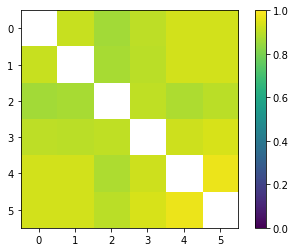

In [31]:
im = plt.imshow(df_square.astype(float).to_numpy())
plt.colorbar()
plt.clim(0,1)

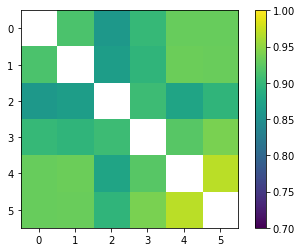

In [32]:
limit = 0.7
df_filt = df_square.copy()
df_filt[df_filt <= limit] = 0

plt.imshow(df_filt.astype(float).to_numpy())
plt.colorbar()
plt.clim(limit,1)

(0.6, 1.0)

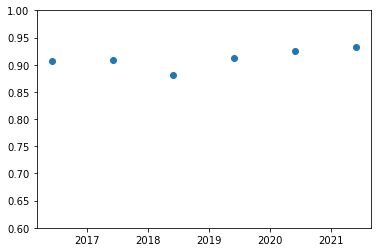

In [33]:
x = pd.to_datetime(df_square.index).to_numpy()
means = df_square.mean(axis=1)
y = means.to_numpy()
plt.scatter(x,y)
# print(means.shape)
plt.ylim(0.6,1)

<AxesSubplot:ylabel='Frequency'>

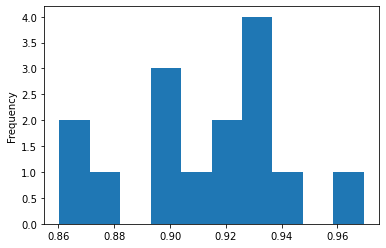

In [34]:
df.ncc.plot.hist()

In [35]:
exclude = []

ts = df.copy()
ts = ts[~ts.ncc.isnull()]

# add date12
ts['date12'] = ts['date1'] + '-' + ts['date2']

# remove problematic dates
ts = ts[(~ts['date1'].isin(exclude)) & (~ts['date2'].isin(exclude))]

# calculate date difference
ts['date1'] = pd.to_datetime(ts['date1'])
ts['date2'] = pd.to_datetime(ts['date2'])
ts['date_diff'] = (ts['date2'] - ts['date1']).dt.days

# calculate day of year
ts['doy1'] = ts.date1.dt.dayofyear
ts['doy2'] = ts.date2.dt.dayofyear

# remove <365 pairs
# ts = ts[ts.date_diff >= 365]

ts.shape

(15, 7)

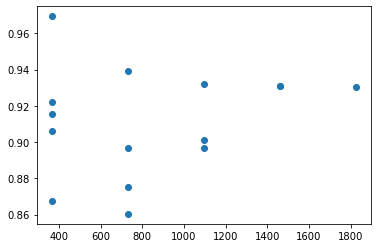

In [36]:
plt.scatter(ts['date_diff'],ts['ncc'])

## Threshold based selection

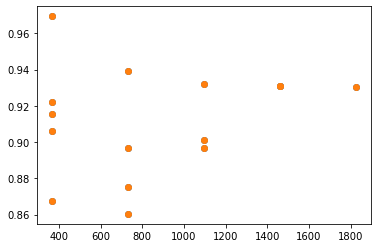

In [37]:
#get min spanning tree
mst = network.threshold_coherence_based_mst(list(ts.date12),list(ts.ncc))
mst = ['20'+x[:7]+'20'+x[7:] for x in mst]

gtt = ts[ts.ncc >= 0.7].copy()

date12_list = list(set(gtt.date12) | set(mst))
pairs = ts[ts.date12.isin(date12_list)].copy().reset_index(drop=True)
pairs.sort_values(['date1','date2'],inplace=True)

pairs['image1'] = [names[x] for x in pairs.date1.dt.strftime('%Y%m%d')]
pairs['image2'] = [names[x] for x in pairs.date2.dt.strftime('%Y%m%d')]

pairs[['image1','image2']].to_csv('pairs.csv',index=False)

plt.scatter(pairs.date_diff,pairs.ncc)
plt.scatter(gtt.date_diff,gtt.ncc)

max perpendicular baseline: 1.00 m
max temporal      baseline: 1826.0 days
showing coherence
data range: [0.8603353033110557, 0.969429257406574]
display range: [0.8603353033110557, 0.969429257406574]
15 pairs for 6 dates


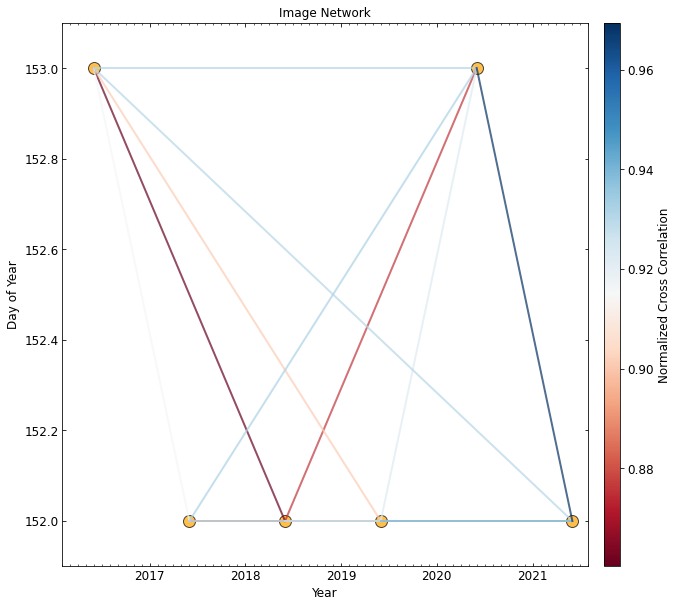

In [38]:
dates = pd.Series(pairs.date1.append(pairs.date2).unique())
dates_txt = dates.dt.strftime('%Y%m%d')
doy = dates.dt.dayofyear

p_dict = {}
p_dict['cohList'] = pairs.ncc.tolist()
p_dict['vlim'] = [pairs.ncc.min(),pairs.ncc.max()]
p_dict['xlabel'] = 'Year'
p_dict['ylabel'] = 'Day of Year'
p_dict['cbar_label'] = 'Normalized Cross Correlation'

f, ax = plt.subplots(1,1,figsize=(10,10))
ax = plot.plot_network(ax,pairs.date12.tolist(),dates_txt,doy,p_dict)
ax.set_title('Image Network')
print(f'{pairs.shape[0]} pairs for {dates.shape[0]} dates')